Portfolio Optimization
Created: 2025.Mar.25

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize


In [2]:
# 종목 리스트 설정
tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'PG', 'XOM', 'TSLA']

# 일별 종가 데이터 참조 기간 결정
startdate_str = '2020-01-01'
enddate_str = '2024-12-31'


In [3]:

# 3개월 미국 국채 수익률 (^IRX 티커)
rf_data = yf.download('^IRX', period='7d', interval='1d')  # 최근 7일

# 가장 최근의 종가 사용 (단위: %)
latest_rf_percent = rf_data['Close'].dropna().iloc[-1]

# 연간 무위험 수익률로 변환 (소수점 표현)
annual_riskFreeRate = latest_rf_percent / 100

try:
    print(f"Latest 3-Month Treasury Rate (Annual): {annual_riskFreeRate:.4%}")
except:
    latest_rf_percent = rf_data['Close'].dropna().iloc[-1].item() / 100
    annual_riskFreeRate = latest_rf_percent / 100
    print(f"Latest 3-Month Treasury Rate (Annual): {annual_riskFreeRate:.4%}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Latest 3-Month Treasury Rate (Annual): 0.0420%


In [4]:
# 일별 무위험 수익률 계산 (연간 무위험 수익률로부터)
rf_daily__recent = (1 + annual_riskFreeRate)**(1/252) - 1  

In [5]:

# 데이터 다운로드
df_zero = yf.download(tickers, start=startdate_str, end=enddate_str)
# 컬럼 명 확인
print(df_zero.columns)

[*********************100%***********************]  7 of 7 completed

MultiIndex([( 'Close', 'AAPL'),
            ( 'Close',  'JNJ'),
            ( 'Close',  'JPM'),
            ( 'Close', 'MSFT'),
            ( 'Close',   'PG'),
            ( 'Close', 'TSLA'),
            ( 'Close',  'XOM'),
            (  'High', 'AAPL'),
            (  'High',  'JNJ'),
            (  'High',  'JPM'),
            (  'High', 'MSFT'),
            (  'High',   'PG'),
            (  'High', 'TSLA'),
            (  'High',  'XOM'),
            (   'Low', 'AAPL'),
            (   'Low',  'JNJ'),
            (   'Low',  'JPM'),
            (   'Low', 'MSFT'),
            (   'Low',   'PG'),
            (   'Low', 'TSLA'),
            (   'Low',  'XOM'),
            (  'Open', 'AAPL'),
            (  'Open',  'JNJ'),
            (  'Open',  'JPM'),
            (  'Open', 'MSFT'),
            (  'Open',   'PG'),
            (  'Open', 'TSLA'),
            (  'Open',  'XOM'),
            ('Volume', 'AAPL'),
            ('Volume',  'JNJ'),
            ('Volume',  'JPM'),
        

In [ ]:
# In case 'Adj_close' is not pulled properly
if ('Adj Close', tickers[0]) in df_zero.columns:
    pass
else:
    # Build adjusted close table
    adj_close_dict = {}

    for stock in tickers:
        stock_obj = yf.Ticker(stock)
        hist = stock_obj.history(start=startdate_str, end=enddate_str)
        adj_close_dict[stock] = hist['Close']  # This 'Close' is actually adjusted in .history()

    # Combine into a single DataFrame
    df_adj_close = pd.DataFrame(adj_close_dict)

    # Force to use timezone-naive datetime index
    df_adj_close.index = df_adj_close.index.tz_localize(None)

    # Stack adjusted close into same format as yf.download multi-index
    adj_close_stacked = df_adj_close.stack().unstack(level=1)
    adj_close_stacked.columns.name = 'Ticker'

    # Recreate a MultiIndex with ('Adj Close', ticker)
    adj_close_multi = pd.concat([
        df_adj_close[ticker].rename(('Adj Close', ticker))
        # df_adj_close[ticker].rename((ticker, 'Adj Close'))
        for ticker in df_adj_close.columns
    ], axis=1)

    # Reorder axes to match yf.download structure
    adj_close_multi.columns = pd.MultiIndex.from_tuples(adj_close_multi.columns)
    df = pd.concat([df_zero, adj_close_multi], axis=1)

df.head()

Price           Close                                                  \
Ticker           AAPL         JNJ         JPM        MSFT          PG   
Date                                                                    
2020-01-02  72.716072  126.055176  120.733551  153.323257  108.419876   
2020-01-03  72.009125  124.595726  119.140297  151.414124  107.690704   
2020-01-06  72.582916  124.440292  119.045563  151.805511  107.840034   
2020-01-07  72.241547  125.200256  117.021729  150.421371  107.172363   
2020-01-08  73.403648  125.182976  117.934616  152.817352  107.629173   

Price                                  High                          ...  \
Ticker           TSLA        XOM       AAPL         JNJ         JPM  ...   
Date                                                                 ...   
2020-01-02  28.684000  55.137970  72.776598  126.098357  120.742117  ...   
2020-01-03  29.534000  54.694706  72.771752  125.537013  119.906777  ...   
2020-01-06  30.102667  55.114647  72.621654  124.526641  119.080019  ...   
2020-01-07  31.270666  54.663593  72.849224  125.606135  118.726928  ...   
2020-01-08  32.809334  53.839241  73.706279  126.063807  118.485792  ...   

Price        Volume                       Adj Close                          \
Ticker           PG       TSLA       XOM       AAPL        MSFT         JNJ   
Date                                                                          
2020-01-02  8130800  142981500  12456400  72.716072  153.323257  126.055176   
2020-01-03  7970500  266677500  17386900  72.009125  151.414124  124.595726   
2020-01-06  6674400  151995000  20081900  72.582916  151.805511  124.440292   
2020-01-07  7583400  268231500  17387700  72.241547  150.421371  125.200256   
2020-01-08  5385100  467164500  15137700  73.403648  152.817352  125.182976   

Price                                                     
Ticker             JPM          PG        XOM       TSLA  
Date                                                      
2020-01-02  120.733551  108.419876  55.137970  28.684000  
2020-01-03  119.140297  107.690704  54.694706  29.534000  
2020-01-06  119.045563  107.840034  55.114647  30.102667  
2020-01-07  117.021729  107.172363  54.663593  31.270666  
2020-01-08  117.934616  107.629173  53.839241  32.809334  

[5 rows x 42 columns]

In [11]:
# (멀티레벨 컬럼이므로 'Adj Close'로 접근 후 종목별로 나눔)
# 'Adj Close' 컬럼만 추출
data = df.loc[:, ('Adj Close', slice(None))]

# 컬럼 이름 보기 쉽게 조정 (멀티 인덱스 해제)
data.columns = data.columns.droplevel(0)

print(data.head())

Ticker           AAPL        MSFT         JNJ         JPM          PG  \
Date                                                                    
2020-01-02  72.716072  153.323257  126.055176  120.733551  108.419876   
2020-01-03  72.009125  151.414124  124.595726  119.140297  107.690704   
2020-01-06  72.582916  151.805511  124.440292  119.045563  107.840034   
2020-01-07  72.241547  150.421371  125.200256  117.021729  107.172363   
2020-01-08  73.403648  152.817352  125.182976  117.934616  107.629173   

Ticker            XOM       TSLA  
Date                              
2020-01-02  55.137970  28.684000  
2020-01-03  54.694706  29.534000  
2020-01-06  55.114647  30.102667  
2020-01-07  54.663593  31.270666  
2020-01-08  53.839241  32.809334  


In [12]:
# 결측치 확인
print(data.isnull().sum())


Ticker
AAPL    0
MSFT    0
JNJ     0
JPM     0
PG      0
XOM     0
TSLA    0
dtype: int64


In [13]:

# 결측치가 있다면 forward-fill로 보완
if data.isnull().sum().sum() > 0:
    data = data.ffill()


In [14]:

# 수익률 계산 (일간 수익률)
returns = data.pct_change().dropna()

# 수익률 미리보기
print(returns.head())


Ticker          AAPL      MSFT       JNJ       JPM        PG       XOM  \
Date                                                                     
2020-01-03 -0.009722 -0.012452 -0.011578 -0.013196 -0.006725 -0.008039   
2020-01-06  0.007968  0.002585 -0.001248 -0.000795  0.001387  0.007678   
2020-01-07 -0.004703 -0.009118  0.006107 -0.017001 -0.006191 -0.008184   
2020-01-08  0.016086  0.015928 -0.000138  0.007801  0.004262 -0.015080   
2020-01-09  0.021241  0.012493  0.002967  0.003651  0.010938  0.007656   

Ticker          TSLA  
Date                  
2020-01-03  0.029633  
2020-01-06  0.019255  
2020-01-07  0.038801  
2020-01-08  0.049205  
2020-01-09 -0.021945  


In [15]:

# 수익률 통계요약
print(returns.describe())


Ticker         AAPL         MSFT          JNJ          JPM           PG  \
count   1256.000000  1256.000000  1256.000000  1256.000000  1256.000000   
mean       0.001189     0.000995     0.000172     0.000745     0.000426   
std        0.019962     0.019217     0.012385     0.020498     0.013186   
min       -0.128647    -0.147391    -0.072984    -0.149649    -0.087373   
25%       -0.008426    -0.008248    -0.005728    -0.008412    -0.005545   
50%        0.001210     0.001113     0.000119     0.000686     0.000687   
75%        0.012017     0.010946     0.005922     0.009903     0.006868   
max        0.119808     0.142169     0.079977     0.180125     0.120090   

Ticker          XOM         TSLA  
count   1256.000000  1256.000000  
mean       0.000746     0.003026  
std        0.021661     0.042325  
min       -0.122248    -0.210628  
25%       -0.010940    -0.019882  
50%        0.000212     0.001912  
75%        0.012050     0.023789  
max        0.126868     0.219190  


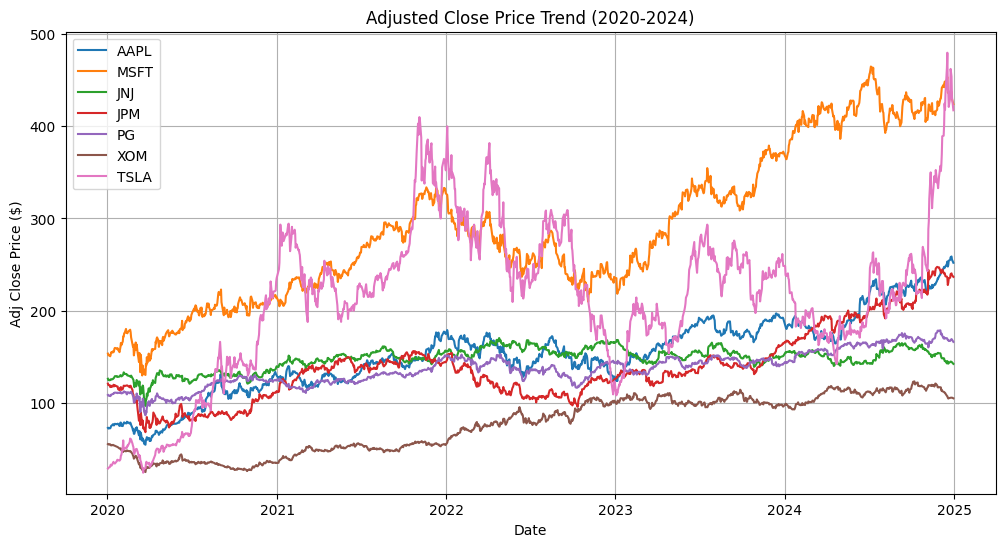

In [16]:

# ---- 시각화 ----

# 1. 일별 종가 추세 확인 (Price Trend)
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)
plt.title('Adjusted Close Price Trend (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.legend()
plt.grid()
plt.show()


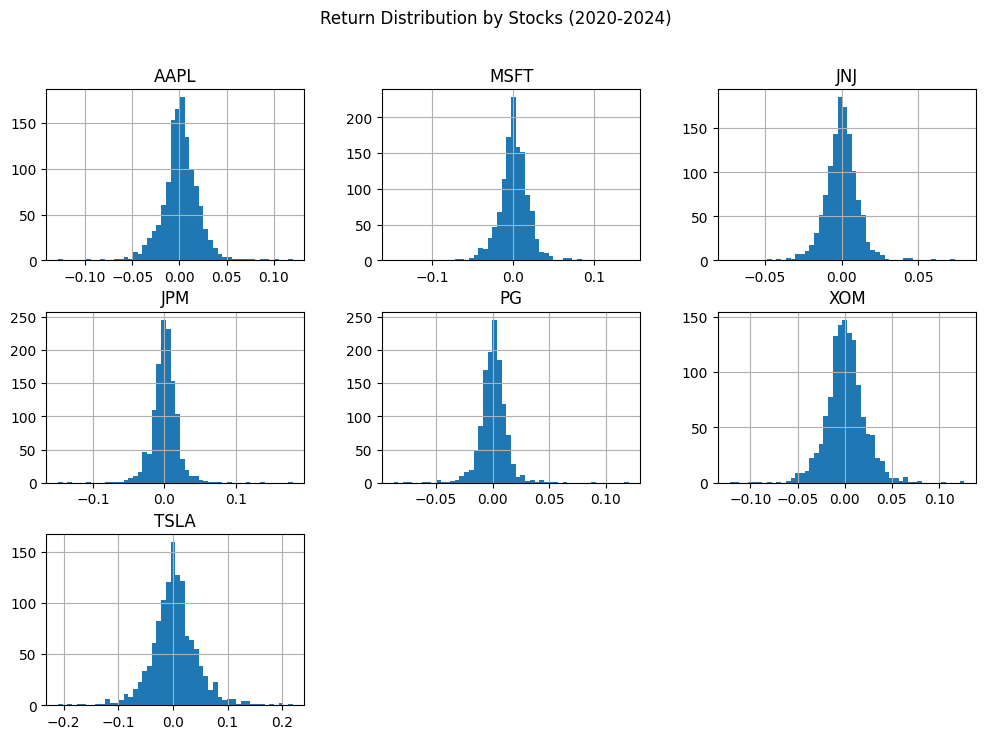

In [17]:

# 2-1. 종목별 수익률 분포 (히스토그램)
returns.hist(bins=50, figsize=(12,8))
plt.suptitle('Return Distribution by Stocks (2020-2024)')
plt.show()


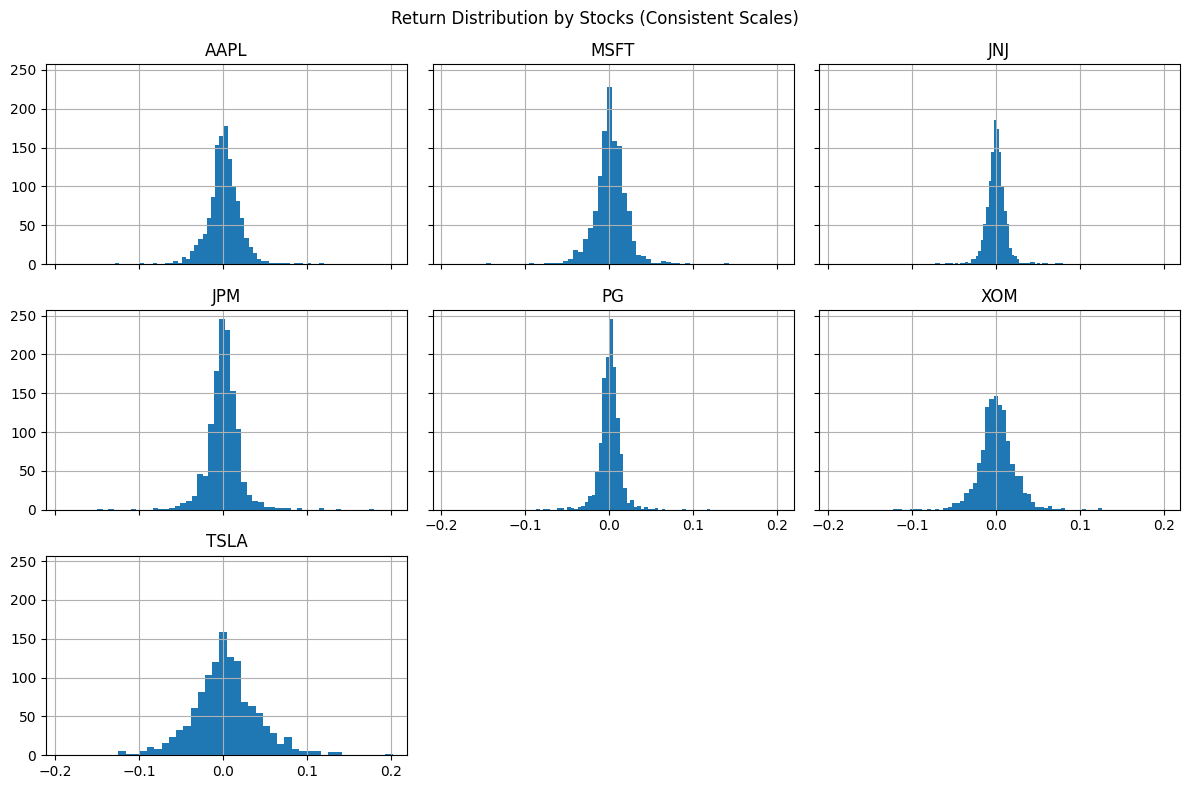

In [18]:
# 2-2. 종목별 수익률 분포 (히스토그램, 축 스케일 통일)

# returns는 이미 계산된 수익률 데이터
axes = returns.hist(bins=50, figsize=(12, 8), sharex=True, sharey=True)

# x축과 y축의 스케일 통일 (범위 강제 지정)
x_min, x_max = returns.min().min(), returns.max().max()
y_max = 0
for ax in axes.flatten():
    y_max = max(y_max, ax.get_ylim()[1])

# 통일된 축 범위 적용
for ax in axes.flatten():
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

plt.suptitle('Return Distribution by Stocks (Consistent Scales)')
plt.tight_layout()
plt.show()

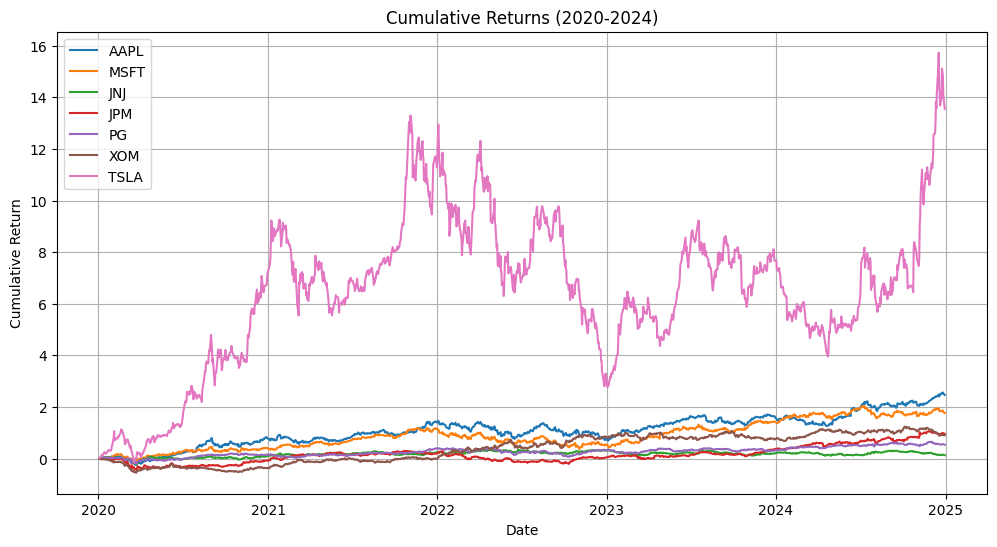

In [19]:

# 3. 종목별 누적 수익률 시각화
cumulative_returns = (1 + returns).cumprod() - 1
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)
plt.title('Cumulative Returns (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


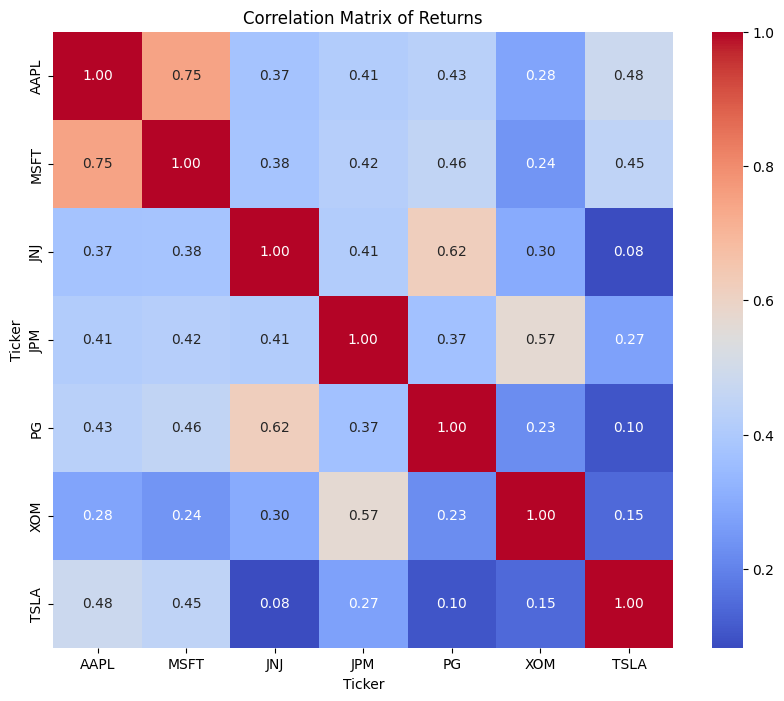

In [20]:

# 4. 상관관계 분석
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Returns')
plt.show()


In [21]:
returns.corr()

Ticker,AAPL,MSFT,JNJ,JPM,PG,XOM,TSLA
Ticker,,,,,,,
AAPL,1.000000,0.748290,0.374566,0.410468,0.429188,0.282181,0.482593
MSFT,0.748290,1.000000,0.379366,0.421323,0.455138,0.242463,0.446344
JNJ,0.374566,0.379366,1.000000,0.410952,0.619354,0.300299,0.082769
JPM,0.410468,0.421323,0.410952,1.000000,0.366382,0.568051,0.273146
PG,0.429188,0.455138,0.619354,0.366382,1.000000,0.226024,0.102040
XOM,0.282181,0.242463,0.300299,0.568051,0.226024,1.000000,0.145289
TSLA,0.482593,0.446344,0.082769,0.273146,0.102040,0.145289,1.000000


# Observations #

Strongest Correlation
AAPL–MSFT: 0.748
- These two large-cap tech stocks are highly correlated and tend to move together.
- Including both in a portfolio provides less diversification benefit.

Pairs with Low Correlation (Good for Diversification)
TSLA–JNJ: 0.083
TSLA–PG: 0.102
TSLA–XOM: 0.145
XOM–MSFT: 0.242
- TSLA shows low correlation with most other assets, making it a good candidate for diversification.

Consider combining low-correlation stocks like TSLA, PG, and XOM to maximize diversification.


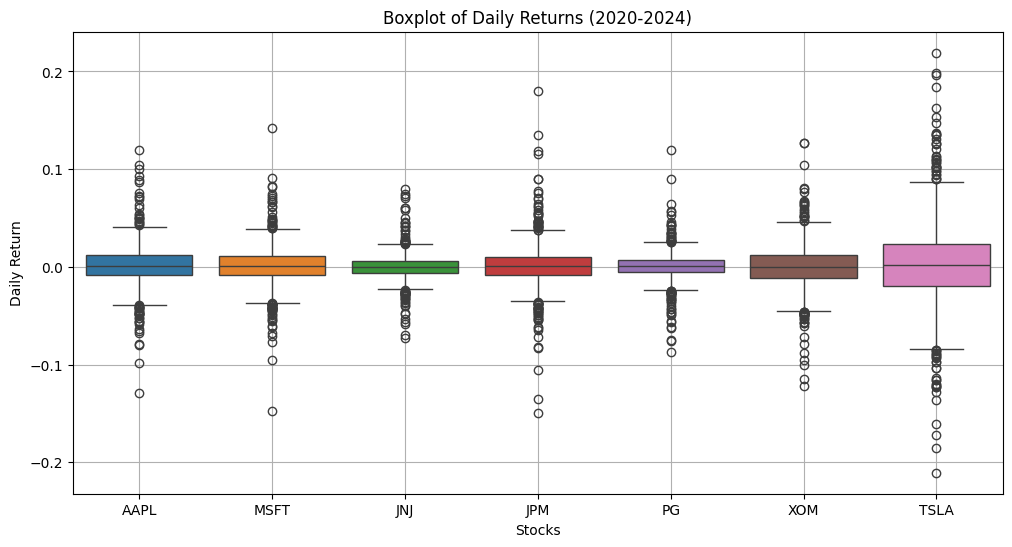

In [22]:

# 5. 종목별 수익률 박스플롯(Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=returns)
plt.title('Boxplot of Daily Returns (2020-2024)')
plt.xlabel('Stocks')
plt.ylabel('Daily Return')
plt.grid()
plt.show()

In [23]:
prc_adj_close = df['Adj Close'].ffill()

# 수익률 계산 (daily returns)
returns = prc_adj_close.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_assets = len(tickers)


In [24]:

# 수익률 & 리스크 계산 함수
def portfolio_performance(weights, mean_returns, cov_matrix):
    port_return = np.dot(weights, mean_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_risk


# 최소 분산 포트폴리오 최적화
def min_variance_portfolio(mean_returns, cov_matrix, initialWeights=num_assets * [1. / num_assets]):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(
        lambda w: np.dot(w.T, np.dot(cov_matrix, w)),        # 최소화 대상: 포트폴리오 분산
        initialWeights,                                      # 초기값
        method='SLSQP',                                      # Sequential Least SQuare Programming
        bounds=bounds,
        constraints=constraints
    )
    return result.x


# SLSQP 기반 최적 포트폴리오 계산
optimal_weights = min_variance_portfolio(mean_returns, cov_matrix)
opt_return, opt_risk = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

# Note: SLSQP may provide only a local minimum, instead of the global minimum.
# Initial values in "minimize()" can have an impact on the return value.


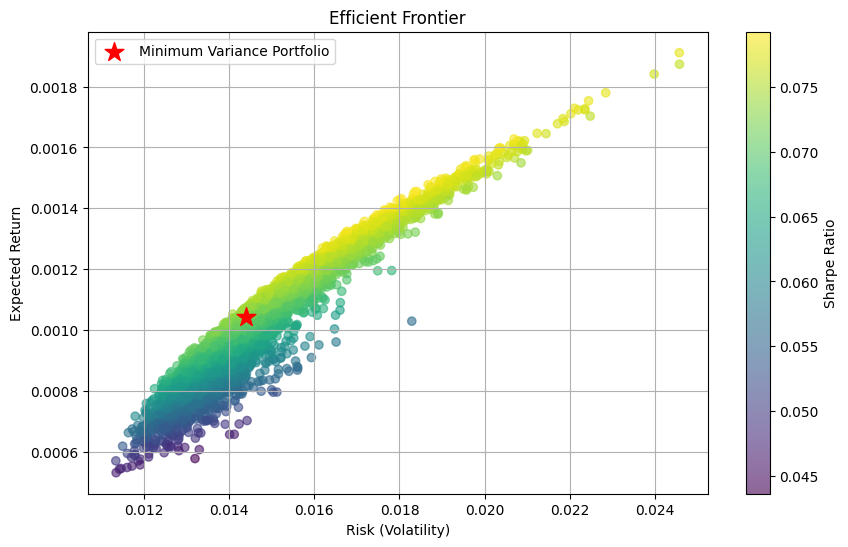

In [25]:

# 샘플 포트폴리오 5,000개 시뮬레이션
weights_list = []
def simulate_random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        ret, risk = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe = (ret - rf_daily__recent) / risk
        results[0, i] = risk
        results[1, i] = ret
        results[2, i] = sharpe
        weights_list.append(weights)
    return results

results = simulate_random_portfolios(5000, mean_returns, cov_matrix)

# 효율적 투자선 시각화
plt.figure(figsize=(10, 6))
plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.scatter(opt_risk, opt_return, c='red', marker='*', s=200, label='Minimum Variance Portfolio')
plt.legend()
plt.grid(True)
plt.show()

Note: The minimum variance portfolio does not have the least variance!
(because scipy.optimize.minimize may return local minima, which depend on initial values)

Other initial values in min_variance_portfolio(mean_returns, cov_matrix, initialWeights) shall be tested to find the true minimum variance portfolio.

In [32]:
# Determine best portfolios at each risk level
portfolios = pd.DataFrame({
    'Risk': results[0],
    'Return': results[1],
    'Sharpe': results[2]
})
for i, ticker in enumerate(tickers):
    portfolios[ticker] = [w[i] for w in weights_list]

# 리스크의 소숫점 세째자리까지를 기준으로 구간을 나눔
portfolios['RiskBucket'] = (portfolios['Risk'] * 1000).astype(int)

# 각 리스크 구간에서 수익률이 가장 높은 포트폴리오만 추출
efficient_set = portfolios.loc[portfolios.groupby('RiskBucket')['Return'].idxmax()].reset_index(drop=True)


In [33]:
efficient_set.head()

,Risk,Return,Sharpe,AAPL,MSFT,JNJ,JPM,PG,XOM,TSLA,RiskBucket
0,0.011799,0.000717,0.060604,0.109663,0.007250,0.352561,0.064971,0.275059,0.098112,0.092384,11
1,0.012914,0.000905,0.069980,0.096915,0.038940,0.285998,0.018317,0.268047,0.135378,0.156404,12
2,0.013930,0.001025,0.073443,0.030989,0.072197,0.221001,0.016709,0.308914,0.142891,0.207300,13
3,0.014957,0.001134,0.075698,0.219727,0.070981,0.144027,0.048976,0.185220,0.149115,0.181954,14
4,0.015992,0.001239,0.077394,0.207195,0.022285,0.019832,0.128830,0.319696,0.078551,0.223611,15


In [34]:
# simulated portfolios with small variance
smallVarianceWeights = efficient_set.iloc[0,3:-1].values
smallVarianceWeights

array([0.10966339, 0.00724961, 0.35256068, 0.0649713 , 0.27505872,
       0.09811196, 0.09238434])

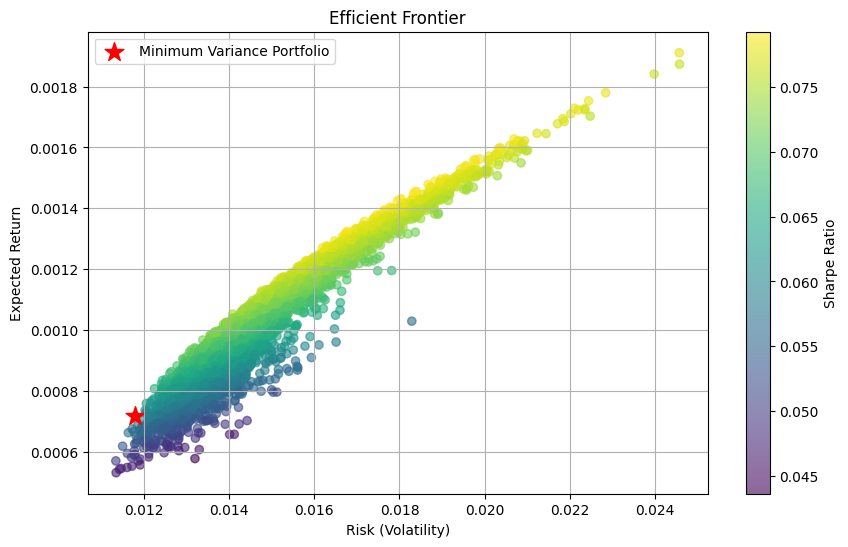

In [35]:
# Determine the minimum variance portfolio again with corrected initial weights

# SLSQP 기반 최적 포트폴리오 계산 (minimize() 내 초기값을 smallVarianceWeights로 수정)
optimal_weights_corrected = min_variance_portfolio(mean_returns, cov_matrix, smallVarianceWeights)
opt_return_corrected, opt_risk_corrected = portfolio_performance(optimal_weights_corrected, mean_returns, cov_matrix)


# 수정된 최소 분산 포트폴리오 시각화
plt.figure(figsize=(10, 6))
plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.scatter(opt_risk_corrected, opt_return_corrected, c='red', marker='*', s=200, label='Minimum Variance Portfolio')
plt.legend()
plt.grid(True)
plt.show()



In [36]:
# DataFrame 생성 (1행, 티커가 컬럼)
df_optimum_weights = pd.DataFrame([optimal_weights_corrected], columns=tickers)

# 보기 좋게 소수점 자릿수 제한 (선택)
df_optimum_weights = df_optimum_weights.round(4)
df_optimum_weights.T

,0
AAPL,0.1097
MSFT,0.0072
JNJ,0.3526
JPM,0.0650
PG,0.2751
XOM,0.0981
TSLA,0.0924


In [37]:
# Export best portfolios
efficient_set.to_csv("efficient_frontier_portfolios.csv", index=False)

In [38]:
# 과거의 Sharpe ratio가 필요한 경우
# 무위험 수익률 기준을 과거 RiskFree 시계열 데이터 기준으로 변경

import pandas_datareader.data as web
import datetime

# 날짜 범위 설정
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 12, 31)

In [39]:
# 무위험 수익률 데이터 다운로드 (FRED - 3개월 T-Bill 수익률)
rf_monthly = web.DataReader('TB3MS', 'fred', start, end)
rf_monthly = rf_monthly.fillna(method='ffill') / 100  # % -> 소수점

# 월간 → 일간 리샘플링 및 수익률 단위 맞추기
rf_daily = rf_monthly.resample('D').ffill()
rf_daily = rf_daily.reindex(returns.index)
daily_rf = (1 + rf_daily) ** (1 / 252) - 1
daily_rf.columns = ['Daily_RF']

# 수익률과 무위험 수익률 병합
returns_with_rf = returns.copy()
returns_with_rf['RiskFree'] = daily_rf['Daily_RF']

# 확인
print(returns_with_rf.head())

Ticker          AAPL      MSFT       JNJ       JPM        PG       XOM  \
Date                                                                     
2020-01-03 -0.009722 -0.012452 -0.011578 -0.013196 -0.006725 -0.008039   
2020-01-06  0.007968  0.002585 -0.001248 -0.000795  0.001387  0.007678   
2020-01-07 -0.004703 -0.009118  0.006107 -0.017001 -0.006191 -0.008184   
2020-01-08  0.016086  0.015928 -0.000138  0.007801  0.004262 -0.015080   
2020-01-09  0.021241  0.012493  0.002967  0.003651  0.010938  0.007656   

Ticker          TSLA  RiskFree  
Date                            
2020-01-03  0.029633   0.00006  
2020-01-06  0.019255   0.00006  
2020-01-07  0.038801   0.00006  
2020-01-08  0.049205   0.00006  
2020-01-09 -0.021945   0.00006  
